# 3. Extracción de Características (BoW Unigramas + Bigramas)

Este notebook construye la representación de **Bolsa de Palabras (Bag of Words - BoW)** a partir del corpus etiquetado generado previamente (noticias **verdaderas** y **falsas**).

## Objetivos
1. Cargar y unificar el corpus (Verdad/Falso).
2. Tokenizar (unigramas).
3. Generar bigramas preservando orden.
4. Eliminar stopwords (unigramas y bigramas que las contengan).
5. Filtrar tokens/bigramas por frecuencia (<3 se eliminan).
6. Aplicar stemming (Snowball Spanish) a vocabulario resultante.
7. Construir matriz BoW (versión cruda, filtrada, con stemming).
8. Persistir vocabularios y matrices.
9. Resumir impacto de cada fase (tamaños y reducción).

## Justificación
El modelo BoW (unigramas+bigramas) permite captar tanto el contenido léxico individual como ciertas dependencias cortas (ej. 'cambio climático', 'falsa noticia').
La reducción por stopwords y frecuencia controla ruido; el stemming agrupa variantes flexivas (ej. 'gobiernos' -> 'gobiern').

## Salidas esperadas
- `bow_vocab_raw.json` (vocabulario antes de filtrados).
- `bow_vocab_filtered.json` (tras stopwords + frecuencia).
- `bow_vocab_stemmed.json` (vocabulario final stemmed).
- `bow_matrix_raw.npz` / `bow_matrix_filtered.npz` / `bow_matrix_stemmed.npz`.
- `stats_bow_fases.json` (conteos comparativos).

## Dependencias
`pandas`, `numpy`, `scikit-learn`, `nltk` (stopwords y SnowballStemmer), `scipy` (para guardar matrices esparsas).

Si alguna no está instalada se instalará dinámicamente.

In [43]:
"""\nCelda de dependencias y utilidades básicas\n- Garantiza instalación mínima (solo si falta) para reproducibilidad controlada.\n- Evita reinstalar librerías ya presentes y centraliza imports para otras celdas.\n"""
from __future__ import annotations
import sys
import subprocess
import importlib
import json
import math
import re
from pathlib import Path
from collections import Counter
from typing import Iterable, List, Tuple, Dict

# --- Instalación perezosa (solo si falta) ---
REQUIRED = [
    'pandas',
    'numpy',
    'scikit-learn',
    'nltk',
    'scipy'
]
for _pkg in REQUIRED:
    try:
        importlib.import_module(_pkg)
    except ImportError:
        subprocess.run([sys.executable, '-m', 'pip', 'install', _pkg], check=True)

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Descargar recurso stopwords si no está disponible
try:
    stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')

print('Dependencias listas.')

Dependencias listas.


### Configuración y utilidades
Centralizamos rutas, constantes y funciones auxiliares para que las siguientes celdas sean más legibles.

In [44]:
"""\nConfiguración de rutas y utilidades léxicas.\nSe apoya únicamente en imports ya cargados en la celda de dependencias para evitar redundancias.\n"""
# Rutas base (PROJECT_ROOT ya es cwd del notebook)
PROJECT_ROOT = Path.cwd()
CORPUS_CSV = r'..\corpus\2_preprocesamiento\2_corpus_preprocesado.csv'
FEATURES_DIR = PROJECT_ROOT 
# Subcarpetas organizadas
VOCAB_DIR = FEATURES_DIR / 'vocabularios'
MATRIX_DIR = FEATURES_DIR / 'matrices'
STATS_DIR = FEATURES_DIR / 'estadisticas'
EVOL_DIR = STATS_DIR / 'evolucion'
ANALISIS_DIR = EVOL_DIR / 'analisis_evolucion'
TAB_DIR = ANALISIS_DIR / 'tablas'
FIG_DIR = ANALISIS_DIR / 'figuras'
for d in (FEATURES_DIR, VOCAB_DIR, MATRIX_DIR, STATS_DIR, EVOL_DIR, ANALISIS_DIR, TAB_DIR, FIG_DIR):
    d.mkdir(parents=True, exist_ok=True)

MIN_FREQ = 3  # Frecuencia mínima para filtrar términos

print('Rutas configuradas:')
print('CSV corpus:', CORPUS_CSV)
print('Dir features:', FEATURES_DIR)
print('Vocabularios:', VOCAB_DIR)
print('Matrices:', MATRIX_DIR)
print('Estadísticas:', STATS_DIR)
print('Evolución:', EVOL_DIR)
print('Min freq:', MIN_FREQ)

# ---- Helpers léxicos ----

def tokenize_unigrams(s: str) -> List[str]:
    """Tokenización mínima: separa por espacio y descarta tokens de 1 char no numéricos."""
    out = []
    for tok in s.split():
        if len(tok) < 2 and not tok.isdigit():
            continue
        out.append(tok)
    return out

def to_bigrams(tokens: List[str]) -> List[str]:
    return [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens)-1)] if len(tokens) > 1 else []

def build_vocab(counter: Counter) -> Dict[str,int]:
    return {tok:i for i,(tok,_) in enumerate(sorted(counter.items(), key=lambda x: (-x[1], x[0])))}

# Stopwords (ya descargadas si era necesario)
STOP_ES = set(stopwords.words('spanish'))

def is_stop(tok: str) -> bool:
    return tok in STOP_ES and not tok.isdigit()

def filter_stopwords_uni(counter: Counter) -> Counter:
    return Counter({t:c for t,c in counter.items() if not is_stop(t)})

def filter_stopwords_bi(counter: Counter) -> Counter:
    def bigram_has_stop(bg: str) -> bool:
        w1, w2 = bg.split('_', 1)
        return is_stop(w1) or is_stop(w2)
    return Counter({t:c for t,c in counter.items() if not bigram_has_stop(t)})

def freq_filter(counter: Counter, min_freq: int) -> Counter:
    return Counter({t:c for t,c in counter.items() if c >= min_freq})

stemmer = SnowballStemmer('spanish')

def stem_token(t: str) -> str:
    return stemmer.stem(t)

def stem_unigrams(counter: Counter) -> Counter:
    sc = Counter()
    for tok,f in counter.items():
        sc[stem_token(tok)] += f
    return sc

def stem_bigrams(counter: Counter) -> Counter:
    sc = Counter()
    for bg,f in counter.items():
        w1,w2 = bg.split('_',1)
        sc[f'{stem_token(w1)}_{stem_token(w2)}'] += f
    return sc

def summarize(counter: Counter) -> Dict[str,int]:
    return {'vocab': len(counter), 'tokens': int(sum(counter.values()))}

def pct_reduction(a: int, b: int) -> float:
    return 0.0 if a == 0 else round(100*(1-b/a),2)

print('Funciones auxiliares listas.')

Rutas configuradas:
CSV corpus: ..\corpus\2_preprocesamiento\2_corpus_preprocesado.csv
Dir features: c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow
Vocabularios: c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\vocabularios
Matrices: c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\matrices
Estadísticas: c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas
Evolución: c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion
Min freq: 3
Funciones auxiliares listas.


### Carga de corpus preprocesado existente
Utilizamos directamente `corpus/2_corpus_preprocesado.csv` que contiene columnas con texto limpio (`text_clean`). Esto sustituye la necesidad de reconstruir el corpus desde los JSON iniciales.

In [45]:
import pandas as pd, re, json, math
from pathlib import Path
PRE_CSV = Path.cwd() / '../2_preprocesamiento/2_corpus_preprocesado.csv'
if not PRE_CSV.exists():
    raise FileNotFoundError(f'No existe {PRE_CSV}')
df_all = pd.read_csv(PRE_CSV)
# Normalizamos nombre de columna label a string '0'/'1'
df_all['label'] = df_all['label'].astype(str)
# Seleccionamos campo de texto limpio preferido
TEXT_COL = 'text_clean' if 'text_clean' in df_all.columns else 'text_combined'
df_all = df_all[['label', TEXT_COL]].rename(columns={TEXT_COL: 'text'})
print('Filas cargadas:', len(df_all))
print(df_all.head(2))

Filas cargadas: 7200
  label                                               text
0     1  la ce dictamina que el procedimiento de actuac...
1     1  la guerra del petroleo otra prueba de fuego pa...


### Tokenización de unigramas

El texto ya viene en minúsculas y sin signos. Aplicamos un split simple y filtramos tokens de longitud < 2 salvo que sean numéricos.

In [46]:
def tokenize_unigrams(s: str):
    parts = s.split()
    out = []
    for tok in parts:
        if len(tok) < 2 and not tok.isdigit():
            continue
        out.append(tok)
    return out
df_all['unigrams'] = df_all['text'].astype(str).apply(tokenize_unigrams)
total_tokens = df_all['unigrams'].str.len().sum()
vocab_raw = {}
from collections import Counter
counter_uni = Counter()
for toks in df_all['unigrams']:
    counter_uni.update(toks)
print('Total tokens unigrama:', total_tokens)
print('Vocabulario unigrama bruto:', len(counter_uni))
list(counter_uni.items())[:10]

Total tokens unigrama: 472134
Vocabulario unigrama bruto: 28727


[('la', 24532),
 ('ce', 5),
 ('dictamina', 5),
 ('que', 14374),
 ('el', 19543),
 ('procedimiento', 32),
 ('de', 35328),
 ('actuacion', 53),
 ('contra', 1156),
 ('desinformacion', 52)]

### Generación de bigramas y frecuencias iniciales

Construimos bigramas contiguos sobre la secuencia de unigramas ya filtrada por longitud.

In [47]:
# Generación de bigramas usando helper to_bigrams definido previamente
# Reutilizamos counter_uni existente para construir counter_bi y un combinado inicial

df_all['bigrams'] = df_all['unigrams'].apply(to_bigrams)
counter_bi = Counter()
for toks in df_all['bigrams']:
    counter_bi.update(toks)
print('Total bigramas distintos:', len(counter_bi))
# Combinar frecuencias para referencia antes de filtrados
combined_counter = Counter()
combined_counter.update(counter_uni)
combined_counter.update(counter_bi)
print('Vocabulario total (uni+bi) bruto:', len(combined_counter))
list(combined_counter.items())[:15]

counter_uni_raw = counter_uni.copy()
counter_bi_raw  = counter_bi.copy()

Total bigramas distintos: 181504
Vocabulario total (uni+bi) bruto: 210231


### Filtro de stopwords (manteniendo números)

Se eliminan unigramas que están en la lista de stopwords en español (NLTK) pero se conservan tokens puramente numéricos.
Los bigramas se eliminan si cualquiera de sus dos componentes está en stopwords.

In [48]:
# Filtro de stopwords reutilizando STOP_ES e is_stop definidos en helpers
uni_before_vocab = len(counter_uni)
uni_before_tokens = sum(counter_uni.values())
bi_before_vocab = len(counter_bi)
bi_before_tokens = sum(counter_bi.values())

counter_uni_filtered = filter_stopwords_uni(counter_uni)
counter_bi_filtered = filter_stopwords_bi(counter_bi)

print('Unigramas -> antes vocab:', uni_before_vocab, 'después:', len(counter_uni_filtered))
print('Unigramas tokens -> antes:', uni_before_tokens, 'después:', sum(counter_uni_filtered.values()))
print('Bigramas -> antes vocab:', bi_before_vocab, 'después:', len(counter_bi_filtered))
print('Bigramas tokens -> antes:', bi_before_tokens, 'después:', sum(counter_bi_filtered.values()))

counter_uni = counter_uni_filtered
counter_bi = counter_bi_filtered
list(counter_uni.most_common(10))

Unigramas -> antes vocab: 28727 después: 28554
Unigramas tokens -> antes: 472134 después: 267570
Bigramas -> antes vocab: 181504 después: 76802
Bigramas tokens -> antes: 464934 después: 114630


[('gobierno', 2347),
 ('mas', 1638),
 ('pp', 1303),
 ('catalunya', 1198),
 ('si', 1184),
 ('iniciativa', 966),
 ('madrid', 965),
 ('presidente', 909),
 ('per', 909),
 ('partido', 882)]

### Filtrado por frecuencia (<3)

Se eliminan unigramas y bigramas cuya frecuencia total sea menor a 3.

In [49]:
MIN_FREQ = 3
uni_before = len(counter_uni)
bi_before = len(counter_bi)
counter_uni_freq = Counter({t:c for t,c in counter_uni.items() if c >= MIN_FREQ})
counter_bi_freq = Counter({t:c for t,c in counter_bi.items() if c >= MIN_FREQ})
print(f'Unigramas >= {MIN_FREQ}:', len(counter_uni_freq), ' (antes', uni_before, ')')
print(f'Bigramas >= {MIN_FREQ}:', len(counter_bi_freq), ' (antes', bi_before, ')')
counter_uni = counter_uni_freq
counter_bi = counter_bi_freq
list(counter_uni.most_common(10))

Unigramas >= 3: 11741  (antes 28554 )
Bigramas >= 3: 4361  (antes 76802 )


[('gobierno', 2347),
 ('mas', 1638),
 ('pp', 1303),
 ('catalunya', 1198),
 ('si', 1184),
 ('iniciativa', 966),
 ('madrid', 965),
 ('presidente', 909),
 ('per', 909),
 ('partido', 882)]

In [50]:
from collections import Counter

# =============== RAW (sin stopwords, sin stemming) ===============
# Filtrado de frecuencia sobre contadores RAW
counter_uni_raw_freq = Counter({t:c for t,c in counter_uni_raw.items() if c >= MIN_FREQ})
counter_bi_raw_freq  = Counter({t:c for t,c in counter_bi_raw.items()  if c >= MIN_FREQ})

# Doc tokens RAW (unigramas + bigramas, sin stopwords ni stemming)
allowed_uni_raw = set(counter_uni_raw_freq.keys())
allowed_bi_raw  = set(counter_bi_raw_freq.keys())

def doc_tokens_raw(row):
    u = [t for t in row['unigrams'] if t in allowed_uni_raw]
    b = [t for t in row['bigrams']  if t in allowed_bi_raw]
    return u + b

df_all['tokens_raw'] = df_all.apply(doc_tokens_raw, axis=1)
docs_raw = df_all['tokens_raw'].apply(lambda ts: ' '.join(ts))

# Vocabulario RAW
def build_vocab(counter):
    return {tok:i for i,(tok,_) in enumerate(sorted(counter.items(), key=lambda x: (-x[1], x[0])))}

vocab_raw_uni = build_vocab(counter_uni_raw_freq)
vocab_raw_bi  = build_vocab(counter_bi_raw_freq)

vocab_raw = {}
idx = 0
for d in (vocab_raw_uni, vocab_raw_bi):
    for tok in d:
        if tok not in vocab_raw:
            vocab_raw[tok] = idx; idx += 1

# =============== STEM (sin stopwords, con stemming) ===============
# Stemming sobre contadores RAW (no filtrados por stopwords)
stem_uni_raw = stem_unigrams(counter_uni_raw)   # helpers ya definidos en tu notebook
stem_bi_raw  = stem_bigrams(counter_bi_raw)

# Filtrado de frecuencia sobre los STEM crudos
stem_uni_raw_freq = Counter({t:c for t,c in stem_uni_raw.items() if c >= MIN_FREQ})
stem_bi_raw_freq  = Counter({t:c for t,c in stem_bi_raw.items()  if c >= MIN_FREQ})

# Combinar en un solo diccionario de stems (uni+bi)
stem_only_combined = dict(stem_uni_raw_freq)
for bg, f in stem_bi_raw_freq.items():
    stem_only_combined[bg] = stem_only_combined.get(bg, 0) + f

# Vocab STEM-only
vocab_stem_only = {tok:i for i,(tok,_) in enumerate(sorted(stem_only_combined.items(), key=lambda x: (-x[1], x[0])))}

# Doc tokens STEM-only: stemmear tokens de cada doc y filtrar por vocab_stem_only
def stem_tok_raw(t):
    if '_' in t:
        a, b = t.split('_', 1)
        return stem_token(a) + '_' + stem_token(b)  # helper ya definido
    return stem_token(t)

df_all['tokens_stem_only'] = df_all.apply(
    lambda row: [stem_tok_raw(t) for t in (row['unigrams'] + row['bigrams'])],
    axis=1
)

allowed_stem_only = set(vocab_stem_only.keys())
df_all['tokens_stem_only'] = df_all['tokens_stem_only'].apply(lambda toks: [t for t in toks if t in allowed_stem_only])
docs_stem_only = df_all['tokens_stem_only'].apply(lambda ts: ' '.join(ts))

print('Docs listos -> RAW / STOP / STEM / BOTH')


Docs listos -> RAW / STOP / STEM / BOTH


### Stemming (Normalización Morfológica)
Aplicamos Snowball Stemmer para español sobre unigramas y cada componente de los bigramas filtrados. Objetivos:
- Reducir variantes flexivas ("gobiernos", "gobierno") a una raíz común.
- Disminuir dimensionalidad del vocabulario final.
Nota: El stemming se aplica después de los filtros para evitar procesar ruido innecesario.

In [51]:
# Stemming reutilizando helpers definidos (stem_unigrams / stem_bigrams)
stem_uni_counter = stem_unigrams(counter_uni)
stem_bi_counter = stem_bigrams(counter_bi)
print('Vocab stem unigramas:', len(stem_uni_counter))
print('Vocab stem bigramas:', len(stem_bi_counter))
stem_combined = dict(stem_uni_counter)
for bg,f in stem_bi_counter.items():
    stem_combined[bg] = stem_combined.get(bg,0) + f
print('Vocab stem total:', len(stem_combined))
list(stem_uni_counter.items())[:10]

Vocab stem unigramas: 6347
Vocab stem bigramas: 4181
Vocab stem total: 10528


[('ce', 5),
 ('dictamin', 5),
 ('proced', 47),
 ('actuacion', 78),
 ('desinform', 63),
 ('gobiern', 2377),
 ('merm', 4),
 ('libert', 131),
 ('prens', 90),
 ('ejecut', 543)]

### Construcción de matrices BoW (filtrada y stemmed)
Se generan dos variantes: 
- Filtrada (tras stopwords + frecuencia, tokens originales).
- Stemmed (mismos tokens pero con stemming aplicado).
Se omite la versión *raw* completa para evitar un vocabulario redundante poco útil y porque los contadores originales fueron sobrescritos tras filtrados. Si la necesitas se puede regenerar fácilmente antes de aplicar filtros.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import json, time
# Vocabularios (token -> índice) ordenados por frecuencia desc y luego alfabético para reproducibilidad
def build_vocab(counter):
    return {tok:i for i,(tok,_) in enumerate(sorted(counter.items(), key=lambda x: (-x[1], x[0])))}
vocab_filtered_uni = build_vocab(counter_uni)
vocab_filtered_bi = build_vocab(counter_bi)
# Unimos vocabularios manteniendo offset
vocab_filtered = {}
idx = 0
for d in (vocab_filtered_uni, vocab_filtered_bi):
    for tok in d:
        if tok not in vocab_filtered:
            vocab_filtered[tok] = idx; idx += 1
# Stem vocab (combina unigramas y bigramas ya stemmeados)

In [53]:
def build_stem_vocab(stem_combined_dict):
    return {tok:i for i,(tok,_) in enumerate(sorted(stem_combined_dict.items(), key=lambda x: (-x[1], x[0])))}
vocab_stem = build_stem_vocab(stem_combined)
print('Vocab filtrado tamaño:', len(vocab_filtered))
print('Vocab stemmed tamaño:', len(vocab_stem))

Vocab filtrado tamaño: 16102
Vocab stemmed tamaño: 10528


In [54]:
# Construcción de documentos tokenizados según vocab filtrado
allowed_uni = set(counter_uni.keys())
allowed_bi = set(counter_bi.keys())
def doc_tokens_filtered(row):
    u = [t for t in row['unigrams'] if t in allowed_uni]
    b = [t for t in row['bigrams'] if t in allowed_bi]
    return u + b
df_all['tokens_filtered'] = df_all.apply(doc_tokens_filtered, axis=1)
def stem_tok(t):
    if '_' in t:
        a,b = t.split('_',1); return stem_token(a)+'_'+stem_token(b)
    return stem_token(t)
df_all['tokens_stemmed'] = df_all['tokens_filtered'].apply(lambda toks: [stem_tok(t) for t in toks])
# Convertimos a textos espacio-separado para CountVectorizer fijo
docs_filtered = df_all['tokens_filtered'].apply(lambda ts: ' '.join(ts))
docs_stemmed = df_all['tokens_stemmed'].apply(lambda ts: ' '.join(ts))
print('Ejemplo filtrado:', docs_filtered.iloc[0][:120])
print('Ejemplo stemmed:', docs_stemmed.iloc[0][:120])

Ejemplo filtrado: ce dictamina procedimiento actuacion desinformacion gobierno merma libertad prensa ejecutivo comunitario cree herramient
Ejemplo stemmed: ce dictamin proced actuacion desinform gobiern merm libert prens ejecut comunitari cre herramient aprob constitu bas jur


In [55]:
# Vectorización con vocabulario fijo
vec_filtered = CountVectorizer(vocabulary=vocab_filtered, tokenizer=str.split, lowercase=False, token_pattern=None)
X_filtered = vec_filtered.transform(docs_filtered)
vec_stem = CountVectorizer(vocabulary=vocab_stem, tokenizer=str.split, lowercase=False, token_pattern=None)
X_stem = vec_stem.transform(docs_stemmed)
print('Matriz filtrada shape:', X_filtered.shape)
print('Matriz stemmed shape:', X_stem.shape)
density_filtered = X_filtered.nnz / (X_filtered.shape[0]*X_filtered.shape[1])
density_stem = X_stem.nnz / (X_stem.shape[0]*X_stem.shape[1])
print(f'Densidad filtrada: {density_filtered:.6f}')
print(f'Densidad stemmed: {density_stem:.6f}')













from sklearn.feature_extraction.text import CountVectorizer

# RAW
vec_raw = CountVectorizer(vocabulary=vocab_raw, tokenizer=str.split, lowercase=False, token_pattern=None)
X_raw = vec_raw.transform(docs_raw)

# STOP (ya lo tienes como 'filtered')
vec_filtered = CountVectorizer(vocabulary=vocab_filtered, tokenizer=str.split, lowercase=False, token_pattern=None)
X_filtered = vec_filtered.transform(docs_filtered)

# STEM (sin stopwords, con stemming)
vec_stem_only = CountVectorizer(vocabulary=vocab_stem_only, tokenizer=str.split, lowercase=False, token_pattern=None)
X_stem_only = vec_stem_only.transform(docs_stem_only)

# BOTH (ya lo tienes como 'stemmed')
vec_stem = CountVectorizer(vocabulary=vocab_stem, tokenizer=str.split, lowercase=False, token_pattern=None)
X_stem = vec_stem.transform(docs_stemmed)

print(
    'Shapes:',
    '\n RAW      ', X_raw.shape,
    '\n STOP     ', X_filtered.shape,
    '\n STEM     ', X_stem_only.shape,
    '\n BOTH     ', X_stem.shape
)

def density(X):
    return X.nnz / (X.shape[0]*X.shape[1]) if X.shape[0] and X.shape[1] else 0.0

print('Densidades:',
      '\n RAW   ', f'{density(X_raw):.6f}',
      '\n STOP  ', f'{density(X_filtered):.6f}',
      '\n STEM  ', f'{density(X_stem_only):.6f}',
      '\n BOTH  ', f'{density(X_stem):.6f}')


Matriz filtrada shape: (7200, 16102)
Matriz stemmed shape: (7200, 10528)
Densidad filtrada: 0.002133
Densidad stemmed: 0.003174
Shapes: 
 RAW       (7200, 37565) 
 STOP      (7200, 16102) 
 STEM      (7200, 33949) 
 BOTH      (7200, 10528)
Densidades: 
 RAW    0.002112 
 STOP   0.002133 
 STEM   0.002457 
 BOTH   0.003174


### Persistencia de vocabularios y matrices
Se guardan artefactos organizados en `corpus/3_caracteristicas_bow/`
- `vocabularios/`: vocabularios filtrado y stemmed
- `matrices/`: matrices esparsas BoW
- `estadisticas/`: métricas globales y evolución por fases
Esto asegura reproducibilidad y separación clara de responsabilidades.

In [56]:
# Persistencia organizada en subcarpetas
from scipy import sparse
(VOCAB_DIR / 'vocab_stopwords.json').write_text(json.dumps(vocab_filtered, ensure_ascii=False, indent=2), encoding='utf-8')
(VOCAB_DIR / 'vocab_stemmed_stopwords.json').write_text(json.dumps(vocab_stem, ensure_ascii=False, indent=2), encoding='utf-8')
sparse.save_npz(str(MATRIX_DIR / 'bow_stopwords.npz'), X_filtered, compressed=True)
sparse.save_npz(str(MATRIX_DIR / 'bow_stemmed_stopwords.npz'), X_stem, compressed=True)
stats = {
    'n_docs': int(len(df_all)),
    'vocab_stopwords': int(len(vocab_filtered)),
    'vocab_stemmed': int(len(vocab_stem)),
    'matrix_filtered_shape': X_filtered.shape,
    'matrix_stem_shape': X_stem.shape,
    'density_filtered': density_filtered,
    'density_stemmed': density_stem,
    'min_freq': MIN_FREQ
}
(STATS_DIR / 'bow_stats.json').write_text(json.dumps(stats, indent=2), encoding='utf-8')
print('Guardado:')
print('-', VOCAB_DIR)
print('-', MATRIX_DIR)
print('-', STATS_DIR)
print(stats)








from scipy import sparse
import json

# Vocabularios
(VOCAB_DIR / 'vocab_raw.json').write_text(json.dumps(vocab_raw, ensure_ascii=False, indent=2), encoding='utf-8')
(VOCAB_DIR / 'vocab_stopwords.json').write_text(json.dumps(vocab_filtered, ensure_ascii=False, indent=2), encoding='utf-8')
(VOCAB_DIR / 'vocab_stem_only.json').write_text(json.dumps(vocab_stem_only, ensure_ascii=False, indent=2), encoding='utf-8')
(VOCAB_DIR / 'vocab_stem.json').write_text(json.dumps(vocab_stem, ensure_ascii=False, indent=2), encoding='utf-8')

# Matrices BoW
sparse.save_npz(str(MATRIX_DIR / 'bow_raw.npz'), X_raw, compressed=True)
sparse.save_npz(str(MATRIX_DIR / 'bow_stopwords.npz'), X_filtered, compressed=True)   # ya existía como 'bow_stopwords.npz'
sparse.save_npz(str(MATRIX_DIR / 'bow_stem_only.npz'), X_stem_only, compressed=True)
sparse.save_npz(str(MATRIX_DIR / 'bow_stemmed.npz'), X_stem, compressed=True)        # ya existía como 'bow_stemmed.npz'

# Resumen actualizado
stats.update({
    'vocab_raw': int(len(vocab_raw)),
    'vocab_stem_only': int(len(vocab_stem_only)),
    'matrix_raw_shape': X_raw.shape,
    'matrix_stem_only_shape': X_stem_only.shape,
    'density_raw': density(X_raw),
    'density_stem_only': density(X_stem_only)
})
(STATS_DIR / 'bow_stats.json').write_text(json.dumps(stats, indent=2), encoding='utf-8')

print('Guardado de las 4 variantes completado:')
for p in [VOCAB_DIR, MATRIX_DIR, STATS_DIR]:
    print('-', p)


Guardado:
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\vocabularios
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\matrices
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas
{'n_docs': 7200, 'vocab_stopwords': 16102, 'vocab_stemmed': 10528, 'matrix_filtered_shape': (7200, 16102), 'matrix_stem_shape': (7200, 10528), 'density_filtered': 0.0021329562235195077, 'density_stemmed': 0.003174035904255319, 'min_freq': 3}
Guardado de las 4 variantes completado:
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\vocabularios
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\matrices
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas


### Resumen e interpretación
- La matriz *filtrada* conserva la forma original de tokens antes de stemming.
- La matriz *stemmed* puede reducir dimensionalidad fusionando variantes flexivas.
- Densidades muy bajas son normales en BoW esparso.
Para añadir TF-IDF o limitar top-N por frecuencia se puede aplicar posteriormente sobre `X_filtered` o `X_stem`.

### Resumen cuantitativo de efectos por fase
Recalculamos métricas de vocabulario y tokens para cada etapa: 
1. Tokenización inicial (unigramas, bigramas).
2. Tras stopwords (sin aplicar frecuencia).
3. Tras filtrado por frecuencia (>=3).
4. Tras stemming (vocab final combinado).
Se guarda `bow_stats_evolution.json` para análisis posterior.

In [57]:
import json
from collections import Counter

def compute_evolution(df_unigrams, df_bigrams, counter_uni_filtered, counter_bi_filtered, stem_uni_counter, stem_bi_counter):
    raw_uni = Counter()
    raw_bi = Counter()
    for toks in df_unigrams:
        raw_uni.update(toks)
    for toks in df_bigrams:
        raw_bi.update(toks)
    stop_uni = filter_stopwords_uni(raw_uni)
    stop_bi = filter_stopwords_bi(raw_bi)
    freq_uni = counter_uni_filtered
    freq_bi = counter_bi_filtered
    stem_uni = stem_uni_counter
    stem_bi = stem_bi_counter
    stats = {
        'unigramas': {
            'raw': summarize(raw_uni),
            'stopwords': summarize(stop_uni),
            'freq': summarize(freq_uni),
            'stem': summarize(stem_uni)
        },
        'bigramas': {
            'raw': summarize(raw_bi),
            'stopwords': summarize(stop_bi),
            'freq': summarize(freq_bi),
            'stem': summarize(stem_bi)
        }
    }
    for tipo in ['unigramas','bigramas']:
        base_vocab = stats[tipo]['raw']['vocab']
        base_tokens = stats[tipo]['raw']['tokens']
        for fase in ['stopwords','freq','stem']:
            stats[tipo][fase]['reduction_vocab_%'] = pct_reduction(base_vocab, stats[tipo][fase]['vocab'])
            stats[tipo][fase]['reduction_tokens_%'] = pct_reduction(base_tokens, stats[tipo][fase]['tokens'])
    return stats

stats_evolution = compute_evolution(df_all['unigrams'], df_all['bigrams'], counter_uni, counter_bi, stem_uni_counter, stem_bi_counter)
evo_path = EVOL_DIR / 'bow_stats_evolution.json'
evo_path.write_text(json.dumps(stats_evolution, indent=2), encoding='utf-8')
print('Resumen evolución guardado en', evo_path)
stats_evolution

Resumen evolución guardado en c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion\bow_stats_evolution.json


{'unigramas': {'raw': {'vocab': 28727, 'tokens': 472134},
  'stopwords': {'vocab': 28554,
   'tokens': 267570,
   'reduction_vocab_%': 0.6,
   'reduction_tokens_%': 43.33},
  'freq': {'vocab': 11741,
   'tokens': 246319,
   'reduction_vocab_%': 59.13,
   'reduction_tokens_%': 47.83},
  'stem': {'vocab': 6347,
   'tokens': 246319,
   'reduction_vocab_%': 77.91,
   'reduction_tokens_%': 47.83}},
 'bigramas': {'raw': {'vocab': 181504, 'tokens': 464934},
  'stopwords': {'vocab': 76802,
   'tokens': 114630,
   'reduction_vocab_%': 57.69,
   'reduction_tokens_%': 75.34},
  'freq': {'vocab': 4361,
   'tokens': 35041,
   'reduction_vocab_%': 97.6,
   'reduction_tokens_%': 92.46},
  'stem': {'vocab': 4181,
   'tokens': 35041,
   'reduction_vocab_%': 97.7,
   'reduction_tokens_%': 92.46}}}

### Visualización clara de evolución de vocabulario y tokens
Presentamos tablas y gráficos para comparar, por fase, el tamaño del vocabulario y el número total de ocurrencias (tokens) para unigramas y bigramas. Fases: `raw`, `stopwords`, `freq`, `stem`. Los artefactos consolidados se almacenan bajo `corpus/features_bow/` en subcarpetas estructuradas:

```
corpus/3_caracteristicas_bow/
  vocabularios/
  matrices/
  estadisticas/
    evolucion/
      analisis_evolucion/
        tablas/
        figuras/
```

Esta organización permite reutilizar fácilmente tanto datos tabulares como figuras en informes sin pasos de migración históricos.

Tabla resumen evolución (unigramas y bigramas):


,tipo,fase,vocab,tokens,red_vocab_%,red_tokens_%
4,bigramas,raw,181504,464934,0.00,0.00
5,bigramas,stopwords,76802,114630,57.69,75.34
6,bigramas,freq,4361,35041,97.60,92.46
7,bigramas,stem,4181,35041,97.70,92.46
0,unigramas,raw,28727,472134,0.00,0.00
1,unigramas,stopwords,28554,267570,0.60,43.33
2,unigramas,freq,11741,246319,59.13,47.83
3,unigramas,stem,6347,246319,77.91,47.83


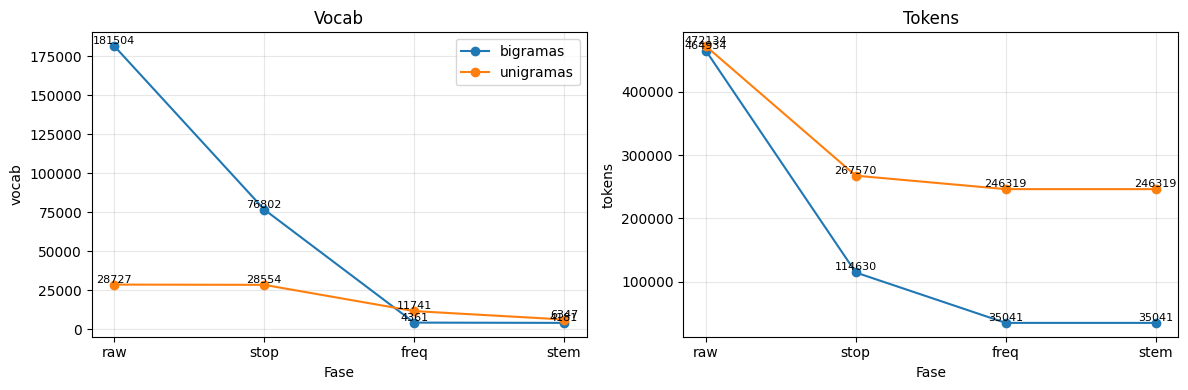


Reducción final raw -> stem:


,tipo,red_vocab_final_%,red_tokens_final_%
0,unigramas,77.91,47.83
1,bigramas,97.70,92.46


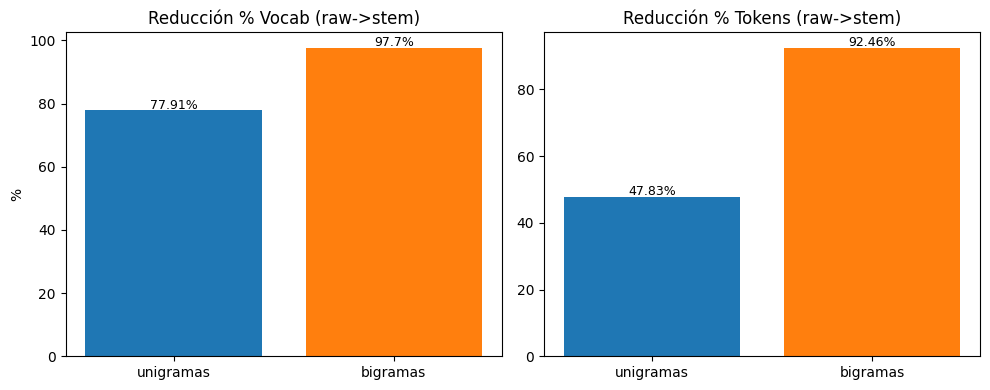

,tipo,fase,vocab,tokens,red_vocab_%,red_tokens_%,fase_ord
4,bigramas,raw,181504,464934,0.00,0.00,0
5,bigramas,stopwords,76802,114630,57.69,75.34,1
6,bigramas,freq,4361,35041,97.60,92.46,2
7,bigramas,stem,4181,35041,97.70,92.46,3
0,unigramas,raw,28727,472134,0.00,0.00,0


In [58]:
# Visualización tabular y gráfica de la evolución (usa imports ya cargados)
# Requiere que bow_stats_evolution.json haya sido generado previamente.

import matplotlib.pyplot as plt

evo_path = EVOL_DIR / 'bow_stats_evolution.json'
if not evo_path.exists():
    raise FileNotFoundError('No se encontró bow_stats_evolution.json en EVOL_DIR. Ejecuta la celda de evolución.')

evo = json.loads(evo_path.read_text(encoding='utf-8'))
rows = []
for tipo, fases in evo.items():
    for fase, vals in fases.items():
        rows.append({
            'tipo': tipo,
            'fase': fase,
            'vocab': vals['vocab'],
            'tokens': vals['tokens'],
            'red_vocab_%': vals.get('reduction_vocab_%', 0.0),
            'red_tokens_%': vals.get('reduction_tokens_%', 0.0)
        })

df_evo = pd.DataFrame(rows)
fase_order = {'raw':0, 'stopwords':1, 'freq':2, 'stem':3}
df_evo['fase_ord'] = df_evo['fase'].map(fase_order)
df_evo = df_evo.sort_values(['tipo','fase_ord'])

print('Tabla resumen evolución (unigramas y bigramas):')
try:
    display(df_evo[['tipo','fase','vocab','tokens','red_vocab_%','red_tokens_%']])
except NameError:
    print(df_evo[['tipo','fase','vocab','tokens','red_vocab_%','red_tokens_%']])

fig, axes = plt.subplots(1,2, figsize=(12,4))
for i,metric in enumerate(['vocab','tokens']):
    ax = axes[i]
    for tipo, sub in df_evo.groupby('tipo'):
        ax.plot(sub['fase_ord'], sub[metric], marker='o', label=tipo)
        for x,y in zip(sub['fase_ord'], sub[metric]):
            ax.text(x, y, str(y), fontsize=8, ha='center', va='bottom')
    ax.set_title(metric.capitalize())
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['raw','stop','freq','stem'])
    ax.set_xlabel('Fase')
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    if i==0:
        ax.legend()
plt.tight_layout()
plt.show()

final_reductions = []
for tipo in ['unigramas','bigramas']:
    raw_vocab = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='raw')]['vocab'].iloc[0]
    stem_vocab = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='stem')]['vocab'].iloc[0]
    raw_tokens = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='raw')]['tokens'].iloc[0]
    stem_tokens = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='stem')]['tokens'].iloc[0]
    red_vocab = 0.0 if raw_vocab==0 else round(100*(1-stem_vocab/raw_vocab),2)
    red_tokens = 0.0 if raw_tokens==0 else round(100*(1-stem_tokens/raw_tokens),2)
    final_reductions.append({'tipo': tipo, 'red_vocab_final_%': red_vocab, 'red_tokens_final_%': red_tokens})

df_final = pd.DataFrame(final_reductions)
print('\nReducción final raw -> stem:')
try:
    display(df_final)
except NameError:
    print(df_final)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax0, ax1 = ax
ax0.bar(df_final['tipo'], df_final['red_vocab_final_%'], color=['#1f77b4','#ff7f0e'])
ax0.set_title('Reducción % Vocab (raw->stem)')
ax0.set_ylabel('%')
for i,v in enumerate(df_final['red_vocab_final_%']):
    ax0.text(i, v+0.5, f'{v}%', ha='center', fontsize=9)
ax1.bar(df_final['tipo'], df_final['red_tokens_final_%'], color=['#1f77b4','#ff7f0e'])
ax1.set_title('Reducción % Tokens (raw->stem)')
for i,v in enumerate(df_final['red_tokens_final_%']):
    ax1.text(i, v+0.5, f'{v}%', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

df_evo.head()

### Exportación de tablas y figuras
Tablas y figuras se organizan bajo:
```
corpus/3_caracteristicas_bow/
  estadisticas/
    evolucion/
      analisis_evolucion/
        tablas/
          bow_stats_evolution_table.csv
          bow_stats_reduccion_final.csv
        figuras/
          evolucion_vocab_tokens.png
          reduccion_final.png
```
Separación clara para reutilización en informes y pipelines posteriores.

In [59]:
# Exportación organizada (tablas/figuras)
import matplotlib.pyplot as plt
import json, pandas as pd

# Reconstruir dataframes si se ejecuta aislado
evo_json_path = EVOL_DIR / 'bow_stats_evolution.json'
if not evo_json_path.exists():
    raise FileNotFoundError('Necesario bow_stats_evolution.json en EVOL_DIR.')
if 'df_evo' not in globals() or 'df_final' not in globals():
    evo = json.loads(evo_json_path.read_text(encoding='utf-8'))
    rows = []
    for tipo, fases in evo.items():
        for fase, vals in fases.items():
            rows.append({
                'tipo': tipo,
                'fase': fase,
                'vocab': vals['vocab'],
                'tokens': vals['tokens'],
                'red_vocab_%': vals.get('reduction_vocab_%', 0.0),
                'red_tokens_%': vals.get('reduction_tokens_%', 0.0)
            })
    import pandas as pd
    df_evo = pd.DataFrame(rows)
    fase_order = {'raw':0, 'stopwords':1, 'freq':2, 'stem':3}
    df_evo['fase_ord'] = df_evo['fase'].map(fase_order)
    df_evo = df_evo.sort_values(['tipo','fase_ord'])
    final_reductions = []
    for tipo in ['unigramas','bigramas']:
        raw_vocab = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='raw')]['vocab'].iloc[0]
        stem_vocab = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='stem')]['vocab'].iloc[0]
        raw_tokens = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='raw')]['tokens'].iloc[0]
        stem_tokens = df_evo[(df_evo.tipo==tipo) & (df_evo.fase=='stem')]['tokens'].iloc[0]
        red_vocab = 0.0 if raw_vocab==0 else round(100*(1-stem_vocab/raw_vocab),2)
        red_tokens = 0.0 if raw_tokens==0 else round(100*(1-stem_tokens/raw_tokens),2)
        final_reductions.append({'tipo': tipo, 'red_vocab_final_%': red_vocab, 'red_tokens_final_%': red_tokens})
    df_final = pd.DataFrame(final_reductions)

csv_evo = TAB_DIR / 'bow_stats_evolution_table.csv'
csv_final = TAB_DIR / 'bow_stats_reduccion_final.csv'
df_evo[['tipo','fase','vocab','tokens','red_vocab_%','red_tokens_%']].to_csv(csv_evo, index=False, encoding='utf-8')
df_final.to_csv(csv_final, index=False, encoding='utf-8')
print('Tablas guardadas en:')
print('-', csv_evo)
print('-', csv_final)

# Figuras
fig, axes = plt.subplots(1,2, figsize=(12,4))
for i,metric in enumerate(['vocab','tokens']):
    ax = axes[i]
    for tipo, sub in df_evo.groupby('tipo'):
        ax.plot(sub['fase_ord'], sub[metric], marker='o', label=tipo)
        for x,y in zip(sub['fase_ord'], sub[metric]):
            ax.text(x, y, str(y), fontsize=8, ha='center', va='bottom')
    ax.set_title(metric.capitalize())
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['raw','stop','freq','stem'])
    ax.set_xlabel('Fase')
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    if i==0:
        ax.legend()
plt.tight_layout()
fig_path1 = FIG_DIR / 'evolucion_vocab_tokens.png'
plt.savefig(fig_path1, dpi=150)
plt.close(fig)

fig2, ax2 = plt.subplots(1,2, figsize=(10,4))
ax0, ax1 = ax2
ax0.bar(df_final['tipo'], df_final['red_vocab_final_%'], color=['#1f77b4','#ff7f0e'])
ax0.set_title('Reducción % Vocab (raw->stem)')
ax0.set_ylabel('%')
for i,v in enumerate(df_final['red_vocab_final_%']):
    ax0.text(i, v+0.5, f'{v}%', ha='center', fontsize=9)
ax1.bar(df_final['tipo'], df_final['red_tokens_final_%'], color=['#1f77b4','#ff7f0e'])
ax1.set_title('Reducción % Tokens (raw->stem)')
for i,v in enumerate(df_final['red_tokens_final_%']):
    ax1.text(i, v+0.5, f'{v}%', ha='center', fontsize=9)
plt.tight_layout()
fig_path2 = FIG_DIR / 'reduccion_final.png'
plt.savefig(fig_path2, dpi=150)
plt.close(fig2)

print('Figuras guardadas en:')
print('-', fig_path1)
print('-', fig_path2)

# Copia JSON evolución (ya está en EVOL_DIR). Para alineación dejamos alias en STATS_DIR si no existe.
json_alias = STATS_DIR / 'bow_stats_evolution.json'
if not json_alias.exists():
    json_alias.write_text((EVOL_DIR / 'bow_stats_evolution.json').read_text(encoding='utf-8'), encoding='utf-8')

{
    'tablas_dir': str(TAB_DIR),
    'figuras_dir': str(FIG_DIR),
    'csv_evo': str(csv_evo),
    'csv_final': str(csv_final),
    'fig_evolucion': str(fig_path1),
    'fig_reduccion': str(fig_path2),
    'json_evo': str(evo_json_path)
}

Tablas guardadas en:
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion\analisis_evolucion\tablas\bow_stats_evolution_table.csv
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion\analisis_evolucion\tablas\bow_stats_reduccion_final.csv
Figuras guardadas en:
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion\analisis_evolucion\figuras\evolucion_vocab_tokens.png
- c:\Users\Usuario\Documents\GitHub\practica1-noticias-falsas\corpus\3_caracteristicas_bow\estadisticas\evolucion\analisis_evolucion\figuras\reduccion_final.png


{'tablas_dir': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-noticias-falsas\\corpus\\3_caracteristicas_bow\\estadisticas\\evolucion\\analisis_evolucion\\tablas',
 'figuras_dir': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-noticias-falsas\\corpus\\3_caracteristicas_bow\\estadisticas\\evolucion\\analisis_evolucion\\figuras',
 'csv_evo': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-noticias-falsas\\corpus\\3_caracteristicas_bow\\estadisticas\\evolucion\\analisis_evolucion\\tablas\\bow_stats_evolution_table.csv',
 'csv_final': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-noticias-falsas\\corpus\\3_caracteristicas_bow\\estadisticas\\evolucion\\analisis_evolucion\\tablas\\bow_stats_reduccion_final.csv',
 'fig_evolucion': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-noticias-falsas\\corpus\\3_caracteristicas_bow\\estadisticas\\evolucion\\analisis_evolucion\\figuras\\evolucion_vocab_tokens.png',
 'fig_reduccion': 'c:\\Users\\Usuario\\Documents\\GitHub\\practica1-notic